# Symphony R vs symphonypy

To demonstrate equivalence of symphony and symphonypy, we will get one of the symphony's prebuilt references from [zenodo](https://zenodo.org/record/5090425#.Y8w0EHZBxPZ) and map another dataset on it via symphony and via symphonypy.  
To compare the results we will count distances between resulting cell's embeddings and estimate the accuracy of cell type prediction.

In [1]:
import os
import sys

import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

from scipy.sparse import csr_matrix
from scipy.stats import ttest_ind
from tqdm.notebook import tqdm

sc.set_figure_params(dpi=150)

JUPYTER_DIR = os.path.dirname(os.path.abspath("__file__"))
SYMPHONY_DIR = os.path.dirname(JUPYTER_DIR)

sys.path.append(SYMPHONY_DIR)

import symphonypy as sp

In [2]:
%load_ext rpy2.ipython
import rpy2
rpy2.rinterface_lib.callbacks.consolewrite_warnerror = lambda x: print(x, end="")

In [3]:
symphony_folder = os.path.join(SYMPHONY_DIR, "symphony")
libsR_fp = os.path.join(symphony_folder, "vignettes", "libs.R")
utilsR_fp = os.path.join(symphony_folder, "vignettes", "utils.R")

## Data loading

### Load Symphony's precomputed PBMC reference

In [4]:
!curl -o pbmcs_10x_reference.rds "https://zenodo.org/record/5090425/files/pbmcs_10x_reference.rds"
!curl -o pbmcs_10x_uwot_model "https://zenodo.org/record/5090425/files/pbmcs_10x_uwot_model"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20.4M  100 20.4M    0     0   9.8M      0  0:00:02  0:00:02 --:--:--  9.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 15.3M  100 15.3M    0     0  8737k      0  0:00:01  0:00:01 --:--:-- 8733k


In [5]:
%%R
ref_pbmcs = readRDS('pbmcs_10x_reference.rds')
ref_pbmcs$save_uwot_path <- "pbmcs_10x_uwot_model"

In [6]:
%%R -o meta_data,vargenes,loadings,R,Z_orig,Z_corr,centroids,Nr,C,n_neighbors,centroids_pc

meta_data <- ref_pbmcs$meta_data
vargenes <- ref_pbmcs$vargenes
loadings <- ref_pbmcs$loadings
R <- ref_pbmcs$R
Z_orig <- ref_pbmcs$Z_orig
Z_corr <- ref_pbmcs$Z_corr
centroids <- ref_pbmcs$centroids
centroids_pc <- ref_pbmcs$centroids_pc
Nr <- ref_pbmcs$cache[[1]]
C <- ref_pbmcs$cache[[2]]
n_neighbors <- ref_pbmcs$umap$n_neighbors

### Create python anndata reference object from the Symphony's precomputed reference

In [7]:
K = C.shape[0]
meta_data.set_index("cell_id", inplace=True)
vargenes.set_index("symbol", inplace=True)

adata_reference = ad.AnnData(csr_matrix((meta_data.shape[0], vargenes.shape[0])))

adata_reference.obs_names = meta_data.index
adata_reference.var_names = vargenes.index
adata_reference.obs = meta_data

# HVG, mean, std
adata_reference.var["highly_variable"] = True
adata_reference.var["mean"] = vargenes["mean"]
adata_reference.var["std"] = vargenes.stddev

# PCA
adata_reference.obsm["X_pca"] = Z_orig.T
adata_reference.obsm["X_pca_harmony"] = Z_corr.T
adata_reference.varm["PCs"] = loadings

# harmony obj
adata_reference.uns["harmony"] = {
    "Nr": Nr.squeeze(1),
    "C": C,
    "Y": centroids.T,
    "centroids_pc": centroids_pc.T,
    "K": K,
    "ref_basis_loadings": "PCs",
    "ref_basis_adjusted": "X_pca_harmony"
}

/tmp/ipykernel_7994/4229466343.py:5: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_reference = ad.AnnData(csr_matrix((meta_data.shape[0], vargenes.shape[0])))


In [8]:
# UMAP
n_comps = Z_orig.shape[0]
n_neighbors = int(n_neighbors[0])

sc.pp.neighbors(
    adata_reference, n_pcs=n_comps, n_neighbors=n_neighbors, use_rep="X_pca_harmony"
)

sc.tl.umap(adata_reference)

### Load query PBMC dataset

In [9]:
DATA_DIR = "/media/HEAP-EPI/miniXun/10kPBMC10x/data/"
adata_query = sc.read_h5ad(os.path.join(DATA_DIR, "PBMC_Satija.h5ad"))

In [10]:
sc.pp.normalize_total(adata_query)
sc.pp.log1p(adata_query)

In [11]:
adata_query

AnnData object with n_obs × n_vars = 17159 × 20729
    obs: 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase'
    uns: 'log1p'

## Symphony (R)

### Map query to reference

load query data to R:

In [12]:
query_exp = adata_query.X.A.T
query_metadata = adata_query.obs
gene_names = adata_query.var_names

In [13]:
%%R -i query_exp,query_metadata,gene_names
rownames(query_exp) <- gene_names

run mapQuery (with Umap mapping):

In [14]:
%%time
%%R
library(symphony)
query = symphony::mapQuery(
                 query_exp,             # query gene expression (genes x cells)
                 query_metadata,        # query metadata (cells x attributes)
                 ref_pbmcs,             # Symphony reference object
                 do_normalize = FALSE,  # perform log(CP10k+1) normalization on query
                 do_umap = TRUE,
                 )

Scaling and synchronizing query gene expression
Found 1307 out of 2357 reference variable genes in query dataset
Project query cells using reference gene loadings
Clustering query cells to reference centroids
Correcting query batch effects
UMAP
All done!
CPU times: user 24.9 s, sys: 3.95 s, total: 28.9 s
Wall time: 16.4 s


In [15]:
%%R -o X_pca_harmony_R

X_pca_harmony_R <- query$Z

save resulted embeddings to adata_query:

In [16]:
adata_query.obsm["X_pca_harmony_R"] = X_pca_harmony_R.T

### Predict cell types via kNN

In [17]:
%%R -i n_neighbors -o knn_pred_cell_type,knn_pred_cell_type_broad

knn_pred_cell_type = as.character(
    class::knn(
        t(ref_pbmcs$Z_corr), t(query$Z), ref_pbmcs$meta_data$cell_type, k = n_neighbors, prob = FALSE
        )
    )
knn_pred_cell_type_broad = as.character(
    class::knn(
        t(ref_pbmcs$Z_corr), t(query$Z), ref_pbmcs$meta_data$cell_type_broad, k = n_neighbors, prob = FALSE
    )
)

save predicted cell types to adata_query:

In [18]:
adata_query.obs["cell_type.R"] = knn_pred_cell_type_broad
adata_query.obs["cell_subtype.R"] = knn_pred_cell_type

## Symphonypy

map query to reference:

In [19]:
%%time
sp.tl.map_embedding(
    adata_query,
    adata_reference,
    adjusted_basis_query="X_pca_harmony",
    query_basis_ref="X_pca_reference"
)
# -> adata_query.obsm["X_pca_harmony"]

1050 out of 2357 genes from reference are missing in query dataset or have zero std in reference, their expressions in query will be set to zero


CPU times: user 7.88 s, sys: 4.91 s, total: 12.8 s
Wall time: 5.15 s


map Umap coords:

In [20]:
sp.tl.ingest(adata_query=adata_query, adata_ref=adata_reference, embedding_method="umap")
# -> adata_query.obsm["X_umap"]

predict cell types via kNN:

In [21]:
labels = ["cell_type", "cell_type_broad"]  # any columns from adata_ref.obs
transferred_labels = ["cell_subtype.py", "cell_type.py"]

# transfer labels via scipy kNN
sp.tl.transfer_labels_kNN(
    adata_query,
    adata_reference,
    labels,
    # kNN args
    n_neighbors,
    query_labels=transferred_labels,
    ref_basis="X_pca_harmony",
    query_basis="X_pca_harmony",
    # kNN kwargs
    weights="distance",
)
# -> adata_query.obs[transferred_labels]

## Distances between symphonypy and symphony R results

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")

count L2 distances:

In [23]:
distances = (((adata_query.obsm["X_pca_harmony_R"] - adata_query.obsm["X_pca_harmony"])**2).sum(axis=1))**0.5

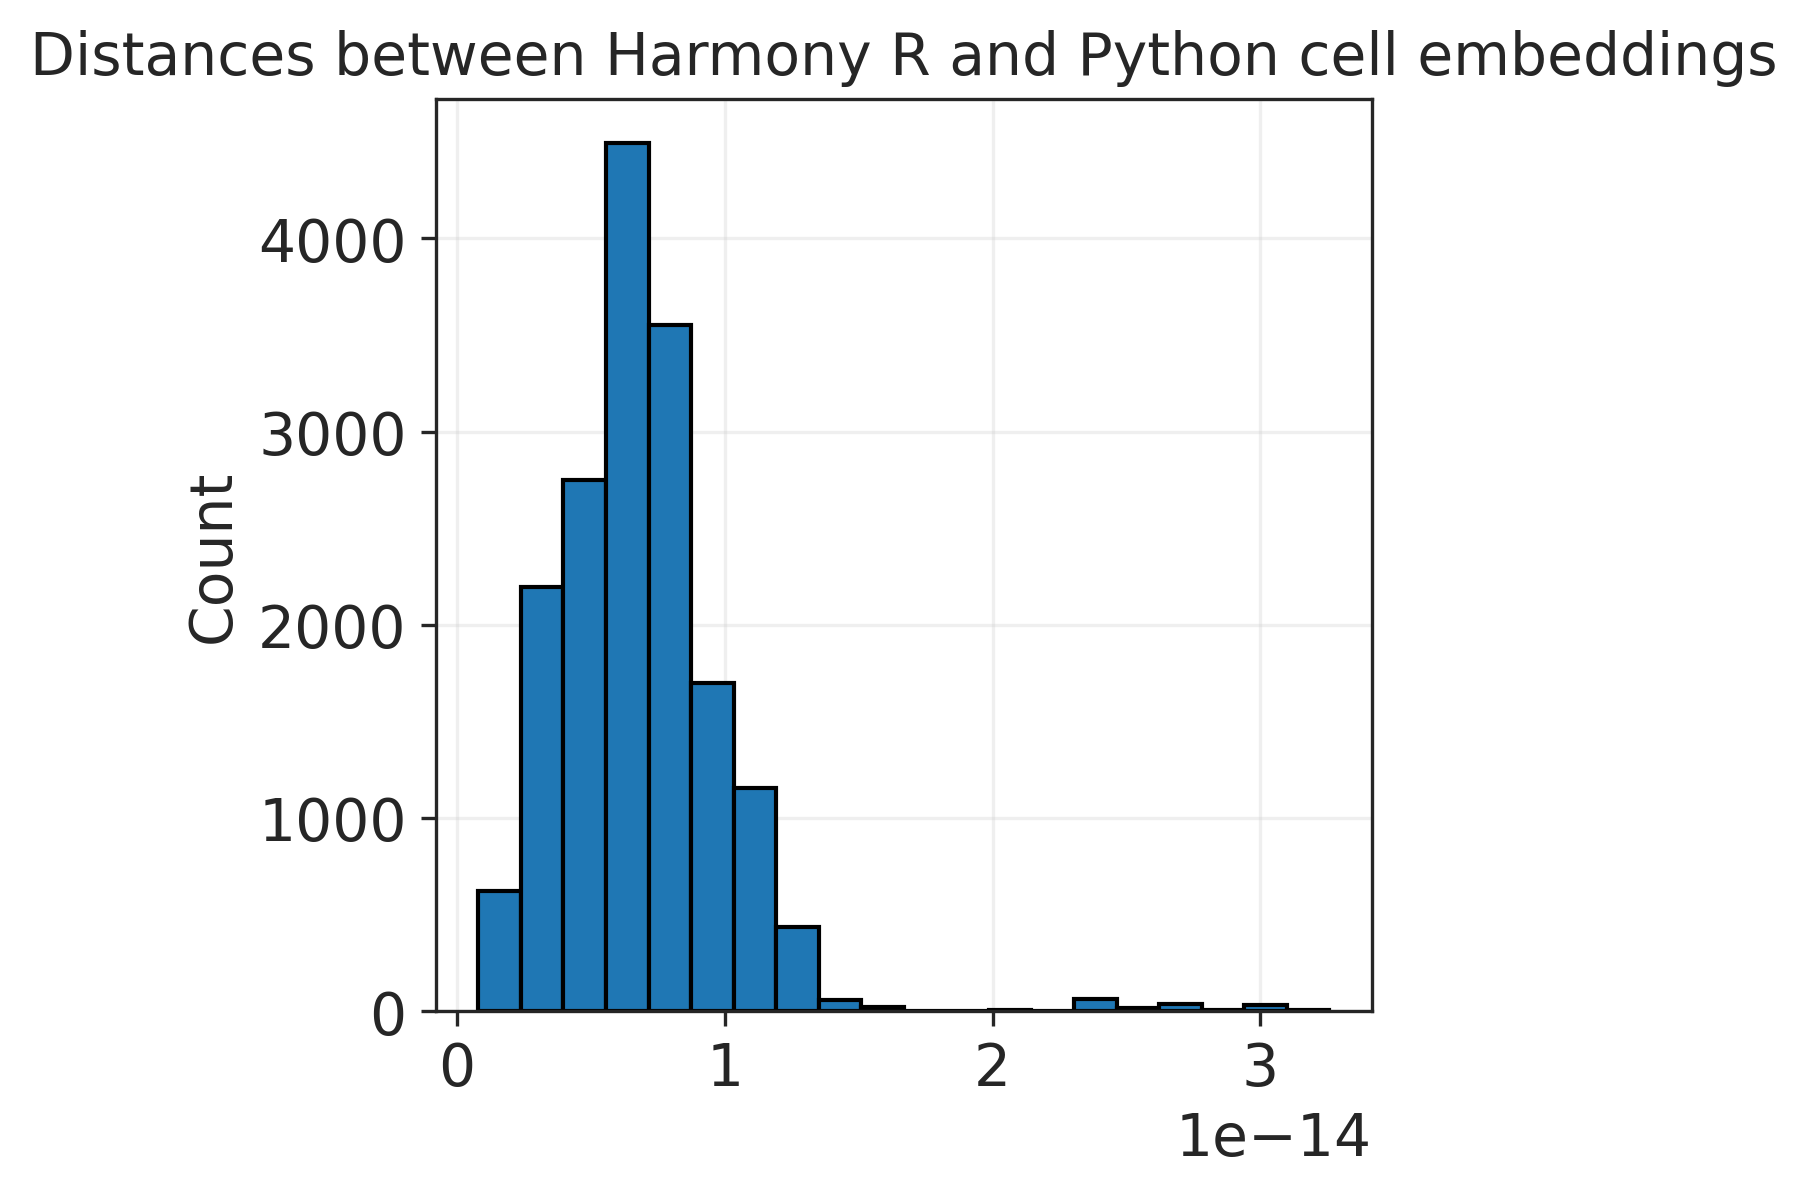

In [24]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.histplot(distances, ax=ax, discrete=False, linewidth=1, edgecolor="black", alpha=1, legend=False, bins=20)
ax.set_title("Distances between Harmony R and Python cell embeddings")
ax.grid(alpha=0.3)

## Cell type prediction accuracy

Cell type names synchronization between reference and query:

In [25]:
cell_type = {
    'CD8 TEM': 'T_CD8',
    'CD8 Naive': 'T_CD8',
    'CD8 TCM': 'T_CD8',
    'CD8 Proliferating': 'T_CD8',
    
    'CD4 TCM': 'T_CD4',
    'CD4 CTL': 'T_CD4',
    'CD4 Naive': 'T_CD4',
    'CD4 Proliferating': 'T_CD4',
    'CD4 TEM': 'T_CD4',
    
    'B naive': 'B',
    'B intermediate': 'B',
    'B memory': 'B',
    'Plasmablast': 'B',
    
    'NK': 'NK',
    'NK_CD56bright': 'NK',
    'NK Proliferating': 'NK',
    
    'gdT': 'other T',
    'Treg': 'other T',
    'MAIT': 'other T',
    'dnT': 'other T',
    
    'CD14 Mono': 'Mono_CD14',
    'CD16 Mono': 'Mono_CD16',
    
    'HSPC': 'HSC',
    'Platelet': 'MK',
    
    'Doublet': 'other',
    'Eryth': 'other',
    
    'pDC': 'DC',
    'cDC1': 'DC',
    'ILC': 'DC',
    'ASDC': 'DC',
    'cDC2': 'DC',
}

In [26]:
adata_query.obs["cell_type"] = [cell_type[ct] for ct in adata_query.obs["celltype.l2"]]

In [27]:
conf_matrix_R = sc.metrics.confusion_matrix(adata_query.obs["cell_type"], adata_query.obs["cell_subtype.R"])
conf_matrix_py = sc.metrics.confusion_matrix(adata_query.obs["cell_type"], adata_query.obs["cell_subtype.py"])

In [28]:
acc_R = sum(adata_query.obs["cell_type"] == adata_query.obs["cell_subtype.R"]) / adata_query.shape[0]
acc_py = sum(adata_query.obs["cell_type"] == adata_query.obs["cell_subtype.py"]) / adata_query.shape[0]

Text(0.02, 0.5, 'query annotation cell_type')

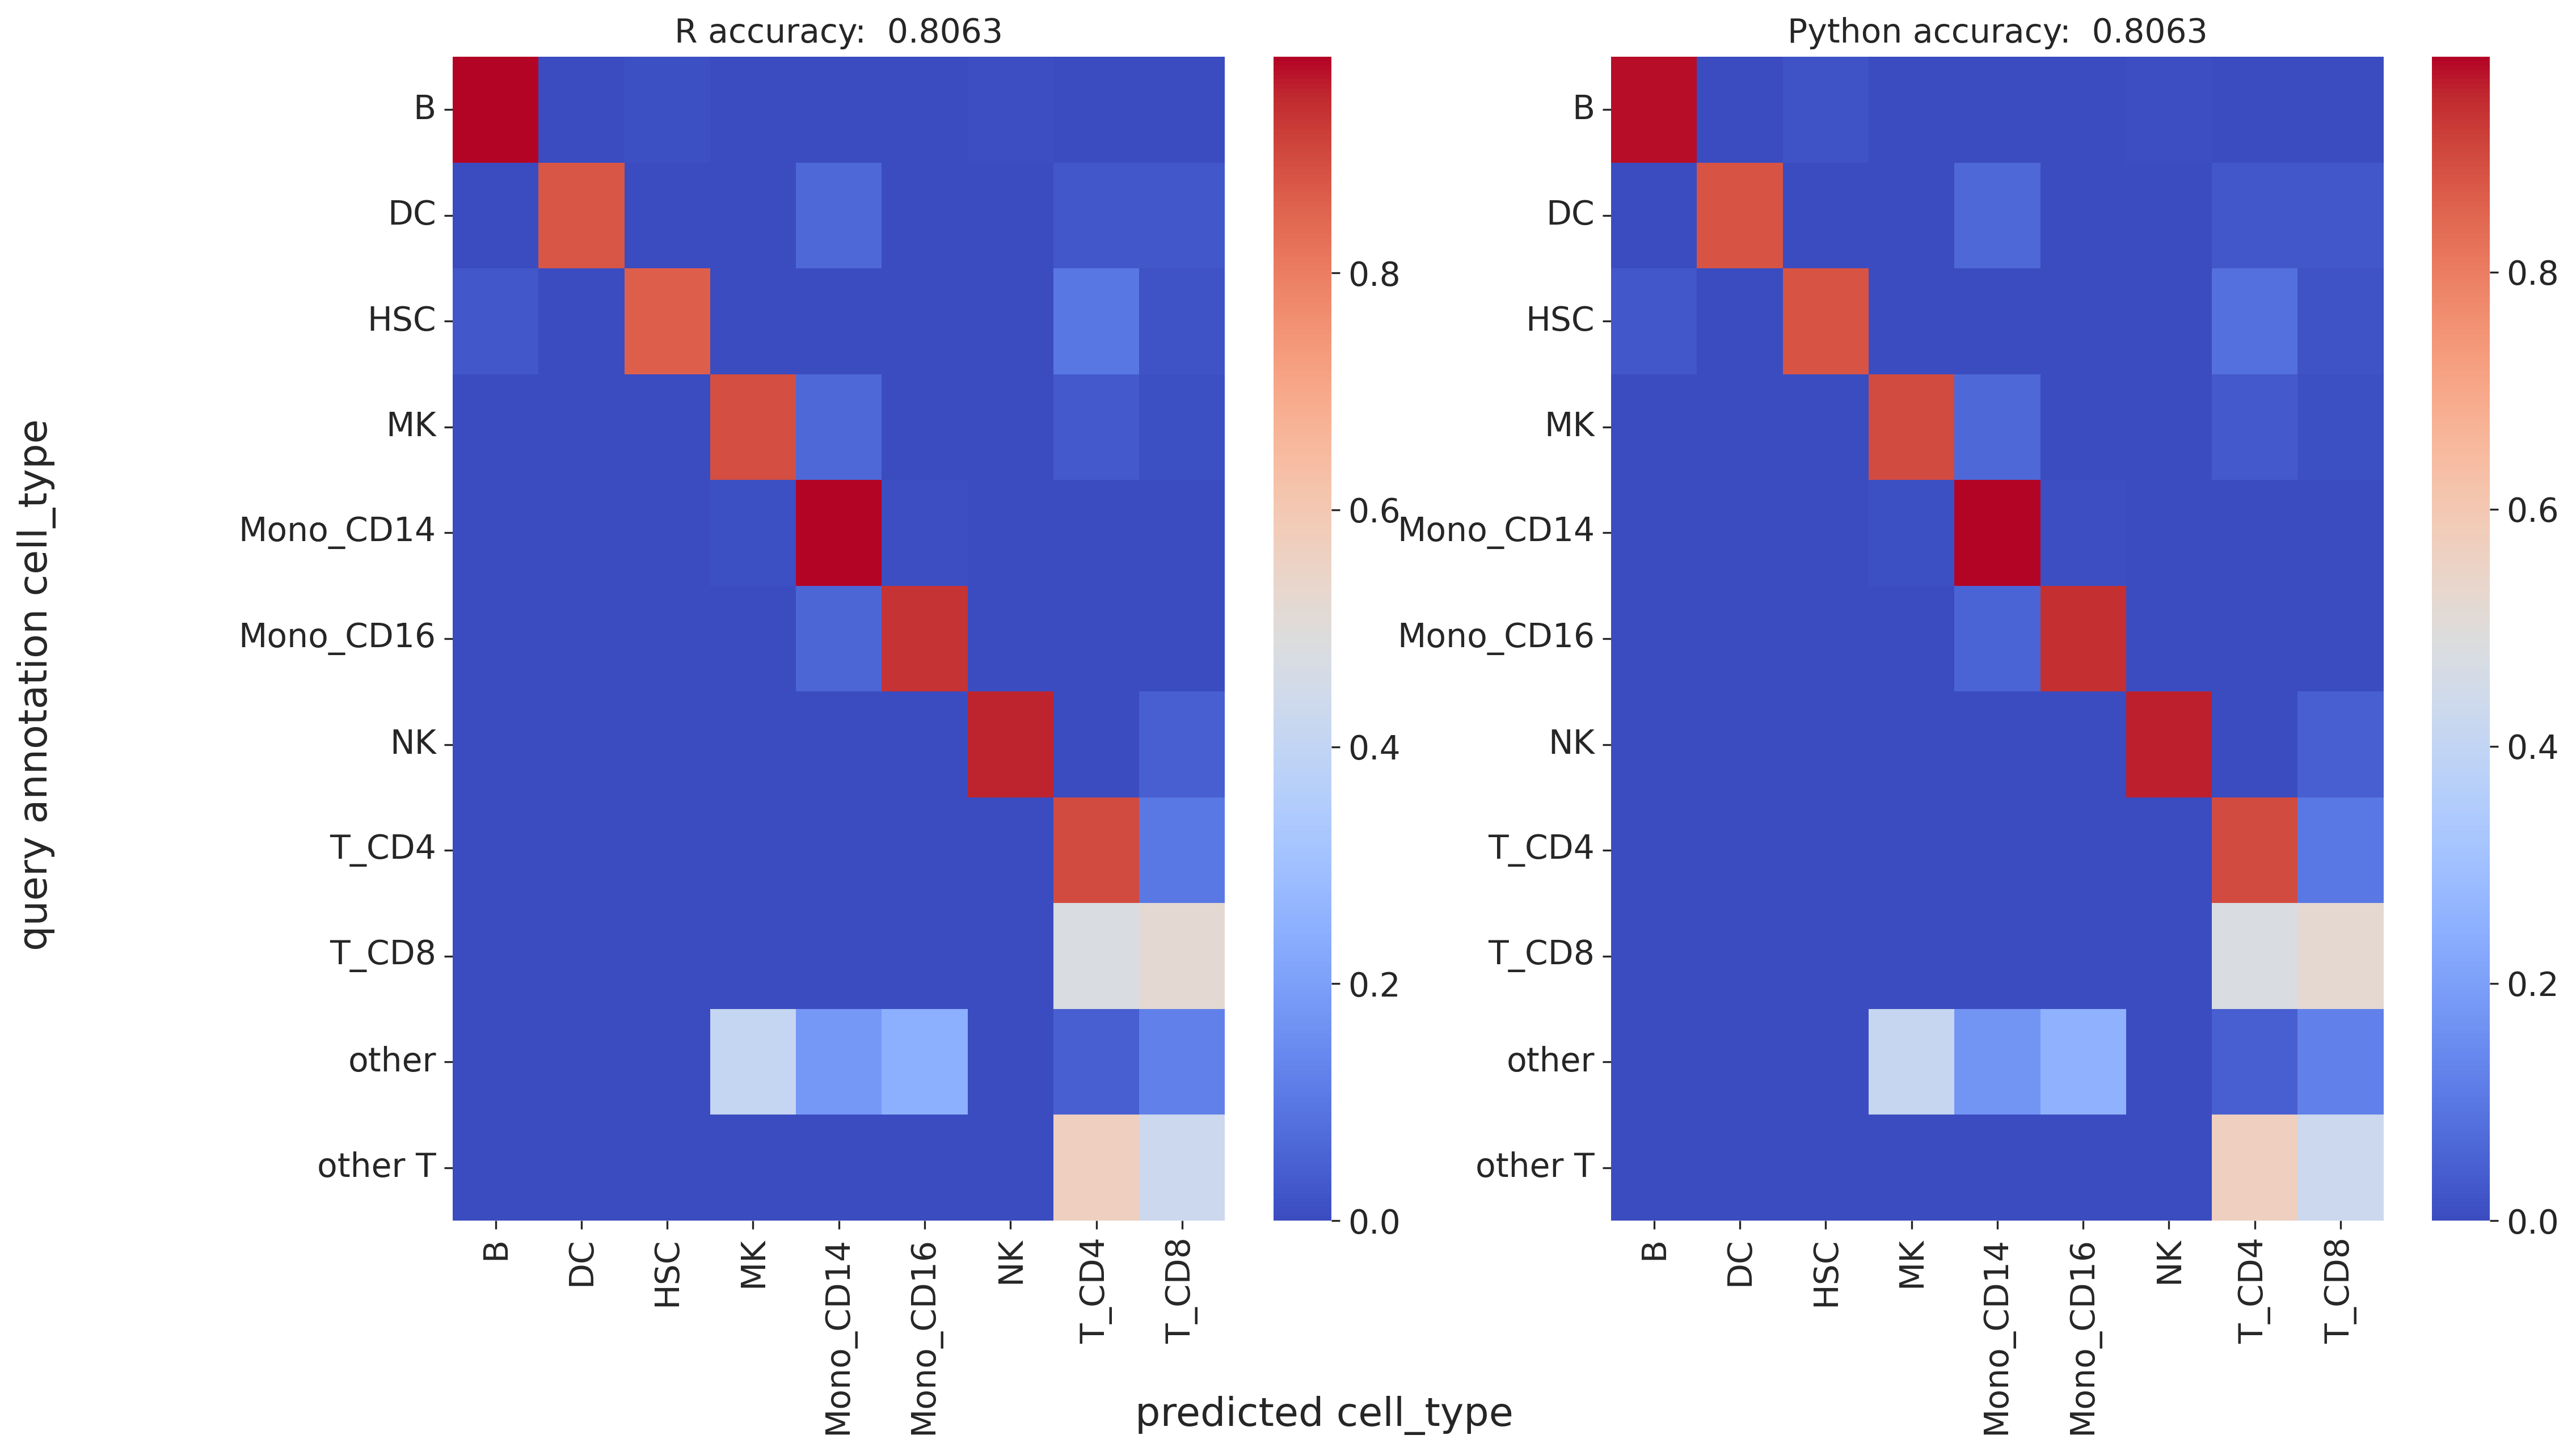

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(16, 9))

hr = sns.heatmap(conf_matrix_R, cmap="coolwarm", ax=axs[0])
hr.set(xlabel=None)
hr.set(ylabel=None)
hr.set_title(f"R accuracy: {acc_R: .4f}")

hpy = sns.heatmap(conf_matrix_py, cmap="coolwarm", ax=axs[1])
hpy.set(xlabel=None)
hpy.set(ylabel=None)
hpy.set_title(f"Python accuracy: {acc_py: .4f}")

fig.supxlabel('predicted cell_type')
fig.supylabel('query annotated cell_type')